In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from operator import attrgetter
import matplotlib.colors as mcolors


In [11]:
# Data Cleaning

df = pd.read_csv('Superstore.csv', encoding='ISO-8859-1', parse_dates=['Order Date'])

df = df.drop(['Row ID'], axis=1, errors='ignore')

df['Ship Date']=pd.to_datetime(df['Ship Date'], format='%m/%d/%Y')

df.drop_duplicates(inplace=True)

df = df.dropna()

df.describe()


,Postal Code,Sales,Quantity,Discount,Profit
count,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000
mean,55191.576403,229.852846,3.789753,0.156188,28.660971
std,32065.074478,623.276074,2.225149,0.206457,234.271476
min,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,23223.000000,17.280000,2.000000,0.000000,1.731000
50%,56560.000000,54.480000,3.000000,0.200000,8.671000
75%,90008.000000,209.940000,5.000000,0.200000,29.364000
max,99301.000000,22638.480000,14.000000,0.800000,8399.976000


  Customer ID  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0    AA-10315      185          5  5563.560       2       2       5   
1    AA-10375       20          9  1056.390       5       5       2   
2    AA-10480      260          4  1790.512       1       1       3   
3    AA-10645       56          6  5086.935       3       3       5   
4    AB-10015      416          3   886.156       1       1       1   

  RFM_Segment  RFM_Score  
0         225          9  
1         552         12  
2         113          5  
3         335         11  
4         111          3  


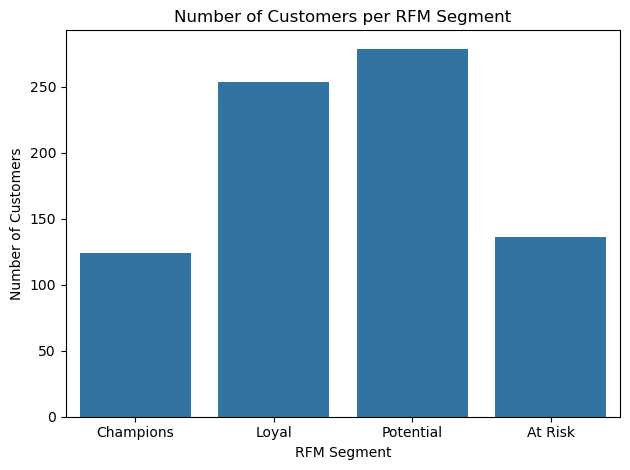

In [34]:
# RFM Analysis

snapshot_date = df['Order Date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({

    'Order Date': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Order ID': 'nunique',                                   # Frequency
    'Sales': 'sum'                                           # Monetory
}).reset_index()

rfm.columns = ['Customer ID', 'Recency', 'Frequency', 'Monetary']

# Ranking each RFM feature on a scale of 1 (lowest) to 5 (highest)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combining scores into a single RFM segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

 # View sample RFM segments
print(rfm.head())

def assign_segment(rfm_score):
    if rfm_score >= 13:
        return 'Champions'
    elif rfm_score >= 10:
        return 'Loyal'
    elif rfm_score >= 6:
        return 'Potential'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(assign_segment)


segment_counts = rfm['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Number of customers per segment']
segment_order = ['Champions', 'Loyal', 'Potential', 'At Risk']

sns.barplot(data=segment_counts,
            x='Segment',
            y='Number of customers per segment',
            order = segment_order)

plt.title('Number of Customers per RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


  Customer ID          AOV  Lifespan (months)           CLTV
0    AA-10315  1112.712000          39.533333  277858.732572
1    AA-10375   117.376667          44.333333   32869.265743
2    AA-10480   447.628000          35.900000  101505.491307
3    AA-10645   847.822500          41.066667  219923.802265
4    AB-10015   295.385333          33.200000   61944.800089


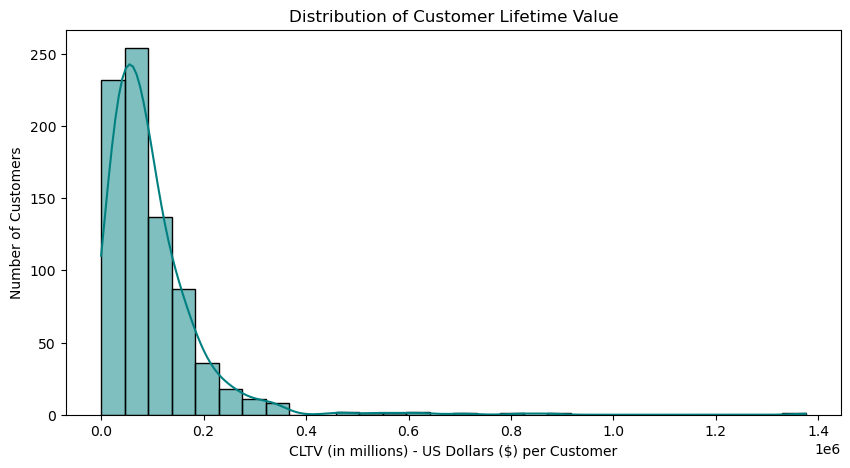

In [30]:
# CLTV (Customer Lifetime Value) Analysis

# AOV - Average Order Value
aov = df.groupby('Customer ID').agg({

    'Sales' : 'sum',
    'Order ID' : 'nunique'
    
}).reset_index()

aov['AOV'] = aov['Sales']/aov['Order ID']

# Frequency
freq = df['Order ID'].nunique()/df['Customer ID'].nunique()

# Customer Lifespan
culs = df.groupby('Customer ID').agg({'Order Date': ['min', 'max']})
culs.columns = ['First', 'Last']
culs['Lifespan'] = (culs['Last'] - culs['First']).dt.days

# Merging AOV and Customer Lifespan
aov_merged = pd.merge(aov, culs, left_on='Customer ID', right_index=True)

# Lifespan in months
aov_merged['Lifespan (months)'] = aov_merged['Lifespan'] / 30

# CLTV per customer
aov_merged['CLTV'] = aov_merged['AOV'] * freq * aov_merged['Lifespan (months)']

print(aov_merged[['Customer ID', 'AOV', 'Lifespan (months)', 'CLTV']].head())

plt.figure(figsize=(10, 5))
sns.histplot(aov_merged['CLTV'], bins=30, kde=True, color='teal')
plt.title('Distribution of Customer Lifetime Value')
plt.xlabel('CLTV (in millions) - US Dollars ($) per Customer')
plt.ylabel('Number of Customers')
plt.show()


    Cohort Month  Cohort Index  Active Customers
0        2014-01             0                32
1        2014-01             1                 3
2        2014-01             3                 2
3        2014-01             4                 2
4        2014-01             6                 2
..           ...           ...               ...
889      2017-07             0                 2
890      2017-07             5                 1
891      2017-09             0                 1
892      2017-10             0                 2
893      2017-11             0                 1

[894 rows x 3 columns]


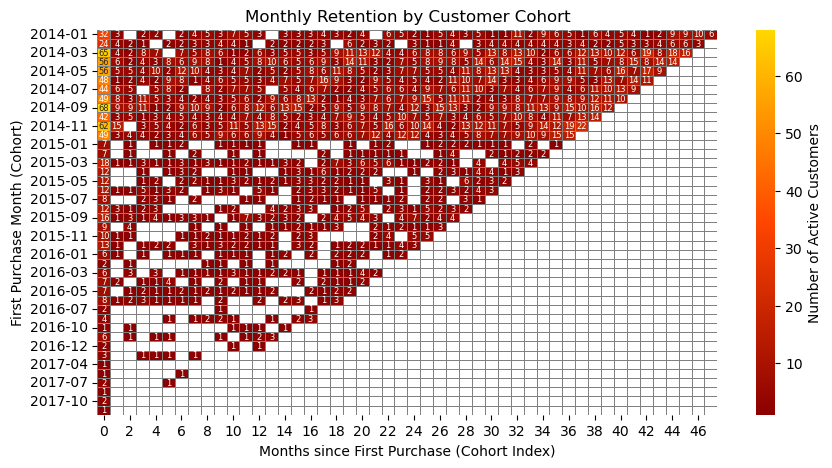

In [31]:
# Cohort Analysis

# Calculating Cohort and Order Month 

df['Order Month'] = df['Order Date'].dt.to_period('M')
first_order = df.groupby('Customer ID')['Order Month'].min()
df['Cohort Month'] = df['Customer ID'].map(first_order)

# Cohort Index

df['Cohort Index'] = (df['Order Month'] - df['Cohort Month']).apply(attrgetter('n'))

# Finding number of active customers per month
 
cohort_data = df.groupby(['Cohort Month','Cohort Index'])['Customer ID'].nunique().reset_index()
cohort_data.rename(columns = {'Customer ID' : 'Active Customers'}, inplace = True)

print(cohort_data)

# Pivoting into a matrix for visualization

cohort_pivot = cohort_data.pivot(index = 'Cohort Month', columns = 'Cohort Index', values = 'Active Customers') 

plt.figure(figsize = (10,5))
colors = ["darkred", "orangered", "gold"]
cmap = mcolors.LinearSegmentedColormap.from_list("red_orange_yellow", colors)
sns.heatmap(cohort_pivot, annot= True, fmt = 'g', cmap=cmap, linewidths=0.5, linecolor='gray', annot_kws={"size":6}, cbar_kws={'label': 'Number of Active Customers'})
plt.title('Monthly Retention by Customer Cohort')
plt.xlabel('Months since First Purchase (Cohort Index)')
plt.ylabel('First Purchase Month (Cohort)')
plt.show()

/var/folders/cz/j1jjb2sj7yv220l886z2jt2h0000gn/T/ipykernel_3772/407194318.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=repeat_count.index, y=repeat_count.values, palette='crest')


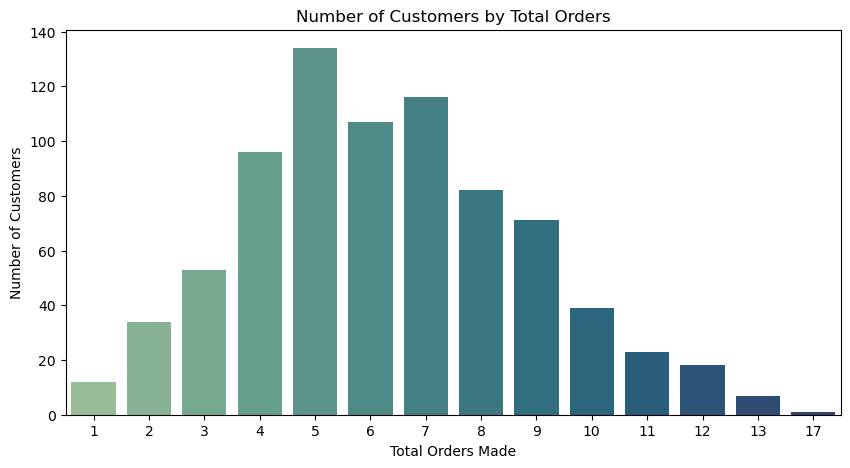

/var/folders/cz/j1jjb2sj7yv220l886z2jt2h0000gn/T/ipykernel_3772/407194318.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= category_count.values, y=category_count.index, palette='rocket')


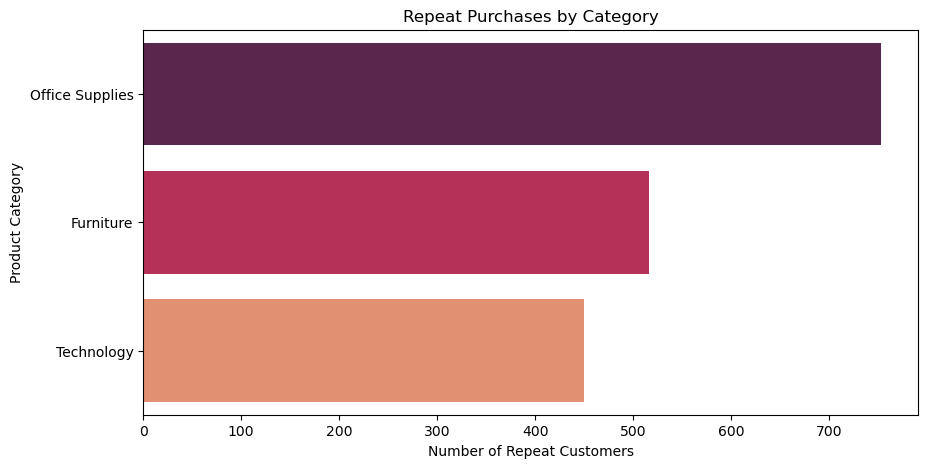

In [39]:
# Repeat Customer Behavior 

# Repeat Purchases per Customer
repeat_customers = df.groupby('Customer ID')['Order ID'].nunique().reset_index()
repeat_customers.columns = ['Customer ID','Total Orders']
repeat_count = repeat_customers['Total Orders'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=repeat_count.index, y=repeat_count.values, palette='crest')

plt.title('Number of Customers by Total Orders')
plt.xlabel('Total Orders Made')
plt.ylabel('Number of Customers')
plt.show()

# Repeat Purchases per Category
category_repeat = df.groupby(['Customer ID','Category'])['Order ID'].nunique().reset_index()
category_repeat = category_repeat[category_repeat['Order ID']>1]
category_count = category_repeat['Category'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x= category_count.values, y=category_count.index, palette='rocket')

plt.title('Repeat Purchases by Category')
plt.xlabel('Number of Repeat Customers')
plt.ylabel('Product Category')
plt.show()

         Number of Customers   Average CLTV    Total CLTV
Region                                                   
West                    1464  103584.372603  1.516475e+08
East                    1272  100323.087335  1.276110e+08
Central                 1134  100836.818827  1.143490e+08
South                    817  104602.731191  8.546043e+07


/var/folders/cz/j1jjb2sj7yv220l886z2jt2h0000gn/T/ipykernel_3772/1535890563.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cltv_city['Total CLTV'], y=cltv_city.index, palette='viridis')


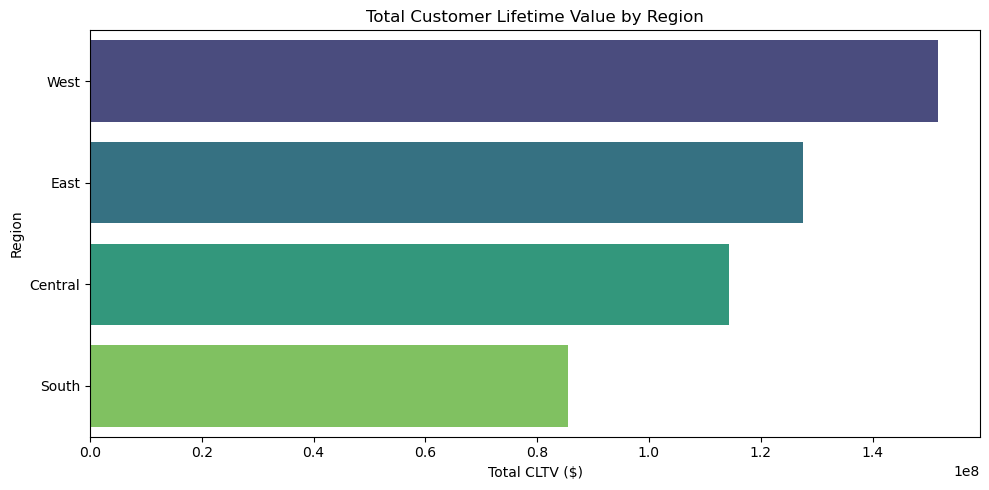

In [36]:
# Geo Loyalty - USA

# Merging 

geo_customer = df[['Customer ID','City','Region']].drop_duplicates()

geo_merged = aov_merged.merge(geo_customer, on = 'Customer ID', how = 'left')

cltv_city = geo_merged.groupby('Region')['CLTV'].agg(['count','mean','sum']).sort_values(by = 'sum', ascending=False)
cltv_city.columns = ['Number of Customers','Average CLTV', 'Total CLTV']

print(cltv_city.head())

plt.figure(figsize=(10, 5))
sns.barplot(x=cltv_city['Total CLTV'], y=cltv_city.index, palette='viridis')

plt.title('Total Customer Lifetime Value by Region')
plt.xlabel('Total CLTV ($)')
plt.ylabel('Region')
plt.tight_layout()
plt.show()